In [1]:

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal as sig

os.chdir(os.path.dirname(os.getcwd()))

import spatial_metrics.helper_functions as hf
import spatial_metrics.detect_peaks as dp

import spatial_metrics.cell_model_base as cs_model
import spatial_metrics.spatial_metrics_base_binarized as pl



In [31]:

srate = 30. # points/frames per second
total_Time = 1000 # in seconds
_lambda = 10 # how much your neuron should spike
environment_edges = [[0,100],[0,100]] # in cm [[x1,x2],[y1,y2]]

x_coordinates,y_coordinates,speed,timevector = cs_model.generate_random_walk(input_srate = srate,input_total_Time = total_Time,heading_srate = 10., speed_srate = 5., rho1  = 1,sigma = 0.02,mu_e  = 0.,smooth_coeff = 0.5,environment_edges = environment_edges)
total_points = timevector.shape[0]


timestamps = cs_model.generate_arrivals(_lambda,total_Time)
I_timestamps = (timestamps*srate).astype(int)

# place cell with one field: x_center and y_center is the location of the place field in the environment; s is the field extension
# modulated_timestamps = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 35,y_center = 25, s = 10)

# grid cell with several fields
modulated_timestamps1 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 50,y_center = 50, s = 5)
modulated_timestamps2 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 10,y_center = 10, s = 5)
# modulated_timestamps3 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 10,y_center = 90, s = 5)
# modulated_timestamps4 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 90,y_center = 90, s = 5)
# modulated_timestamps5 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 90,y_center = 10, s = 5)
# modulated_timestamps = np.unique(np.concatenate([modulated_timestamps1,modulated_timestamps2,modulated_timestamps3,modulated_timestamps4,modulated_timestamps5]))
modulated_timestamps = np.unique(np.concatenate([modulated_timestamps1,modulated_timestamps2]))

# if you want to control for the amount of spikes, set a fixed value for spikes
# num_of_spikes = 1000
# modulated_timestamps = np.sort(np.random.choice(modulated_timestamps,num_of_spikes,replace=False))

calcium_imag,timevector = cs_model.generate_calcium_signal(modulated_timestamps,total_points,srate,noise_level = 0.01, b = 5.)
calcium_events = modulated_timestamps.shape[0]
I_peaks = dp.detect_peaks(calcium_imag,mpd=0.5*srate,mph=1.*np.nanstd(calcium_imag))






/tmp/ipykernel_52705/375236967.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


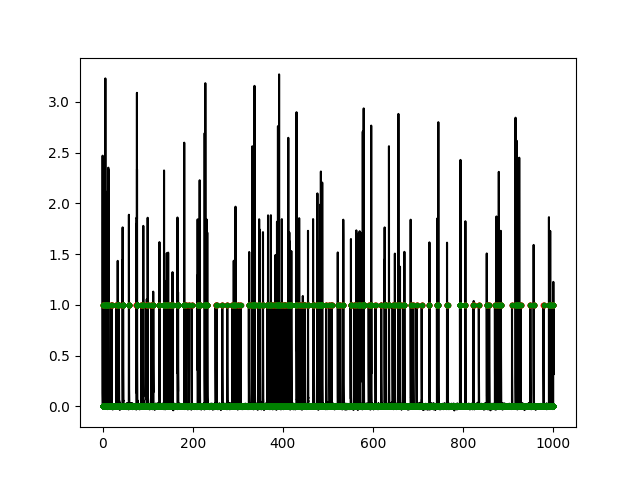

In [32]:
# play with z_threshold just to decide which one is the best for your data
signal_type = 'Binarized'
input_signal_1 = hf.preprocess_signal(calcium_imag,srate,signal_type,z_threshold = 1)
input_signal_2 = hf.preprocess_signal(calcium_imag,srate,signal_type,z_threshold = 2)

plt.figure()
plt.plot(timevector,calcium_imag,'k')
plt.plot(timevector,input_signal_1,'r.')
plt.plot(timevector,input_signal_2,'g.')
plt.show()


In [33]:
signal_type = 'Binarized'
input_signal = hf.preprocess_signal(calcium_imag,srate,signal_type,z_threshold = 1)

input_dict = dict()
input_dict['saving_string'] = 'SpatialMetrics.Binarized'
input_dict['animal_id'] = 'NeuronModel'
input_dict['dataset'] = 'Simulation'
input_dict['day'] = 1
input_dict['neuron'] = 1
input_dict['trial'] = None
input_dict['mean_video_srate'] = srate
input_dict['min_time_spent'] = 0
input_dict['min_visits'] = 0
input_dict['min_speed_threshold'] = 0 
input_dict['x_bin_size'] = 1 # y bin size in cm
input_dict['y_bin_size'] = 1 # y bin size in cm
input_dict['environment_edges'] = environment_edges # in cm
input_dict['shift_time'] = 200
input_dict['num_cores'] = 20
input_dict['num_surrogates'] = 200
input_dict['saving_path'] = None
input_dict['saving'] = False
input_dict['smoothing_size'] = 2
input_dict['percentile_threshold'] = 95
input_dict['min_num_of_pixels'] = 4

place_cell = pl.PlaceCellBinarized(**input_dict)

place_cell_output = place_cell.main(input_signal,timevector,x_coordinates,y_coordinates)


SpatialMetrics.Binarized.NeuronModel.Dataset.Simulation.Day.1.Neuron.1 not saved


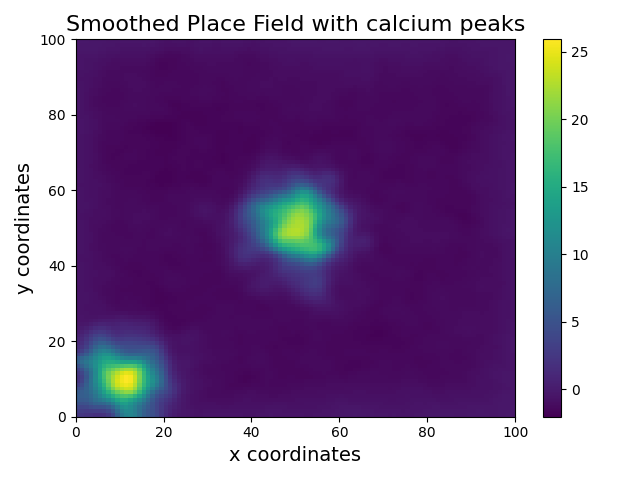

In [34]:

mean_place_field_shuffled = np.nanmean(place_cell_output['place_field_smoothed_shuffled'],0)
std_place_field_shuffled = np.nanstd(place_cell_output['place_field_smoothed_shuffled'],0)
place_field_smoothed = place_cell_output['place_field_smoothed'].copy()
place_field_smoothed_zscored = (place_field_smoothed - mean_place_field_shuffled)/std_place_field_shuffled

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_field_smoothed_zscored)
plt.colorbar()
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



In [20]:
place_cell_output.keys()


dict_keys(['place_field', 'place_field_smoothed', 'place_field_shuffled', 'place_field_smoothed_shuffled', 'occupancy_map', 'visits_map', 'x_grid', 'y_grid', 'x_center_bins', 'y_center_bins', 'numb_events', 'x_peaks_location', 'y_peaks_location', 'events_amplitude', 'num_of_islands', 'islands_x_max', 'islands_y_max', 'sparsity', 'place_cell_extension_absolute', 'place_cell_extension_relative', 'mutual_info_original', 'mutual_info_shuffled', 'mutual_info_zscored', 'mutual_info_centered', 'input_parameters'])

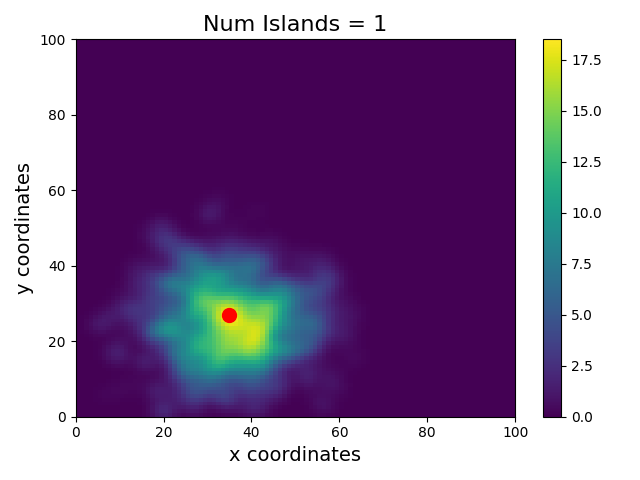

In [19]:
islands_y_max = place_cell_output['islands_y_max']
islands_x_max = place_cell_output['islands_x_max']

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'])
plt.colorbar()
plt.plot(islands_x_max,islands_y_max,'r.',markersize=20)

plt.title('Num Islands = {0}'.format(place_cell_output['num_of_islands']) ,fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


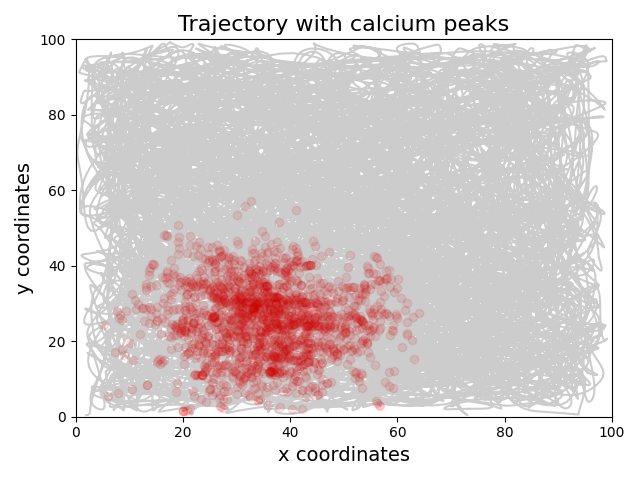

In [23]:

x_peaks_location = place_cell_output['x_peaks_location']
y_peaks_location = place_cell_output['y_peaks_location']

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k',alpha=0.2)
plt.scatter(x_peaks_location,y_peaks_location,alpha=0.1,color='red')
plt.title('Trajectory with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


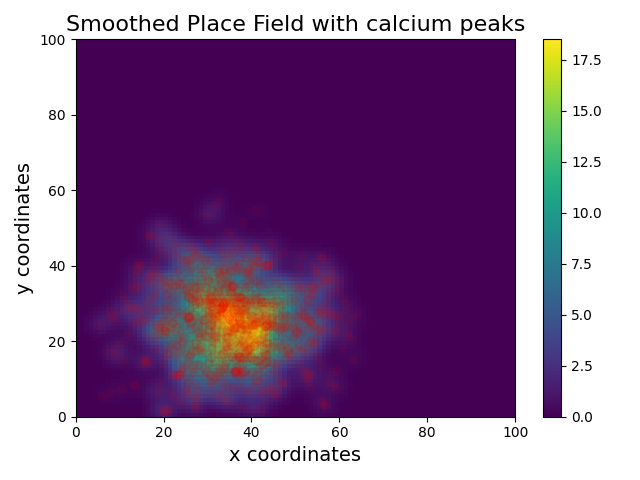

In [26]:
x_peaks_location = place_cell_output['x_peaks_location']
y_peaks_location = place_cell_output['y_peaks_location']

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'])
plt.colorbar()
plt.scatter(x_peaks_location,y_peaks_location,alpha=0.05,color='red')
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


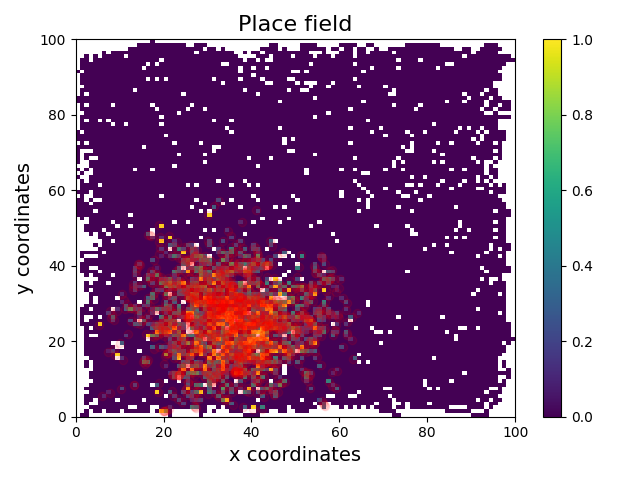

In [27]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field'])
plt.colorbar()
plt.scatter(x_peaks_location,y_peaks_location,alpha=0.1,color='red')
plt.title('Place field',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


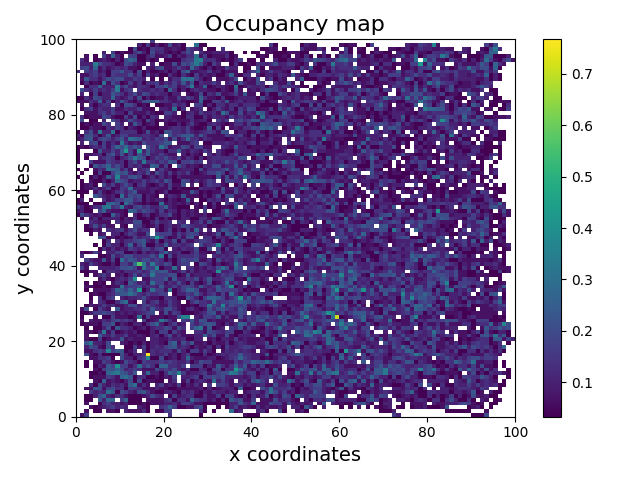

In [28]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['occupancy_map'])
plt.colorbar()
plt.title('Occupancy map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


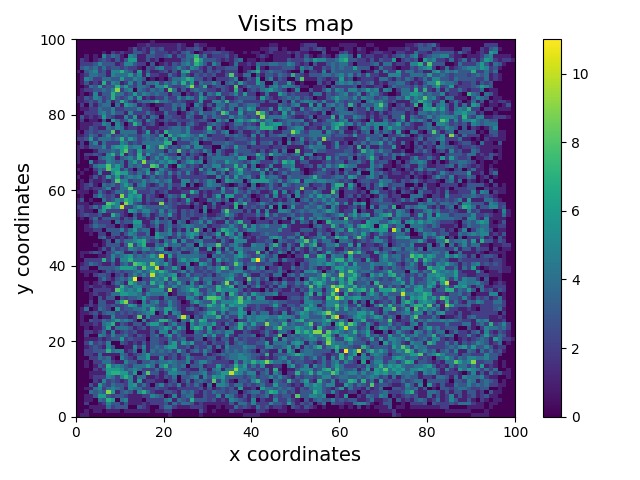

In [29]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['visits_map'])
plt.colorbar()
plt.title('Visits map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


In [17]:
place_cell_output.keys()

dict_keys(['place_field', 'place_field_smoothed', 'place_field_shuffled', 'place_field_smoothed_shuffled', 'occupancy_map', 'visits_map', 'x_grid', 'y_grid', 'x_center_bins', 'y_center_bins', 'numb_events', 'x_peaks_location', 'y_peaks_location', 'events_amplitude', 'num_of_islands', 'islands_x_max', 'islands_y_max', 'sparsity', 'place_cell_extension_absolute', 'place_cell_extension_relative', 'mutual_info_original', 'mutual_info_shuffled', 'mutual_info_zscored', 'mutual_info_centered', 'input_parameters'])

In [12]:
place_cell_output.keys()

dict_keys(['place_field', 'place_field_smoothed', 'place_field_shuffled', 'place_field_smoothed_shuffled', 'occupancy_map', 'visits_map', 'x_grid', 'y_grid', 'x_center_bins', 'y_center_bins', 'numb_events', 'x_peaks_location', 'y_peaks_location', 'events_amplitude', 'num_of_islands', 'islands_x_max', 'islands_y_max', 'place_cell_extension_absolute', 'place_cell_extension_relative', 'mutual_info_original', 'mutual_info_shuffled', 'mutual_info_zscored', 'mutual_info_centered', 'input_parameters'])

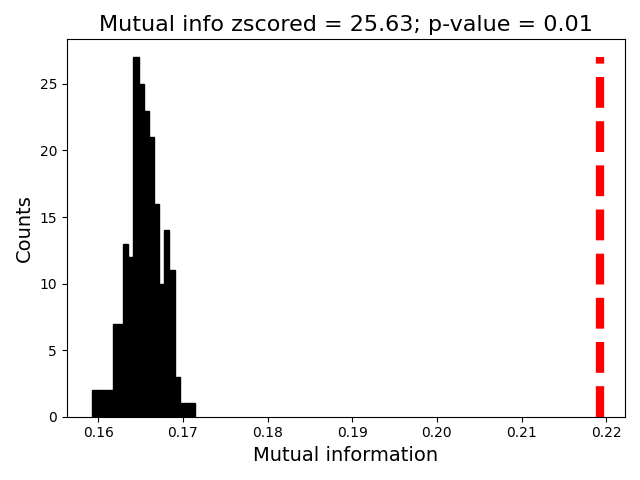

In [21]:
# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = np.sum(place_cell_output['mutual_info_shuffled'] >= place_cell_output['mutual_info_original'])/place_cell_output['mutual_info_shuffled'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['mutual_info_shuffled'].shape[0]
p_value


counts,bins = np.histogram(place_cell_output['mutual_info_shuffled'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['mutual_info_original'],place_cell_output['mutual_info_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['mutual_info_zscored'],p_value),fontsize=16)
plt.xlabel('Mutual information',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


In [25]:
# Surrogate procedure demonstration - take the signal above, shuffle it and check if it is significant (it shouldn't)

# https://www.sciencedirect.com/science/article/pii/S0370157318301340

input_dict = dict()
input_dict['saving_string'] = 'SpatialMetrics.Binarized'
input_dict['animal_id'] = 'NeuronModel'
input_dict['dataset'] = 'Simulation'
input_dict['day'] = 1
input_dict['neuron'] = 1
input_dict['trial'] = None
input_dict['mean_video_srate'] = srate
input_dict['mintimespent'] = 0
input_dict['minvisits'] = 0
input_dict['speed_threshold'] = 0 
input_dict['x_bin_size'] = 1 # y bin size in cm
input_dict['y_bin_size'] = 1 # y bin size in cm
input_dict['environment_edges'] = environment_edges # in cm
input_dict['shift_time'] = 100
input_dict['num_cores'] = 20
input_dict['num_surrogates'] = 200
input_dict['saving_path'] = None
input_dict['saving'] = False
input_dict['smoothing_size'] = 4

place_cell_shuff = pl.PlaceCellBinarized(**input_dict)

calcium_imag_shuffled = place_cell_shuff.get_surrogate(calcium_imag,shift_time=200,mean_video_srate = srate)

z_threshold = 2
filtered_signal_shuffled = hf.eegfilt(calcium_imag_shuffled,srate,0,2,order=2)
norm_signal_shuffled = filtered_signal_shuffled/np.std(filtered_signal_shuffled)

diff_signal_shuffled = np.hstack([np.diff(filtered_signal_shuffled),0])
binarized_signal_shuffled = np.zeros(calcium_imag_shuffled.shape[0])
binarized_signal_shuffled[(norm_signal_shuffled>z_threshold) & (diff_signal_shuffled>0)] = 1


place_cell_output_shuff = place_cell_shuff.main(binarized_signal_shuffled,timevector,x_coordinates,y_coordinates)


/projects/ag-korotkova/v1/korotkova_group/matlab_scripts/Rob/CalciumImaging/scripts/spatial_project/spatial_metrics/spatial_metrics_base_binarized.py:265: RuntimeWarning: Mean of empty slice
  calcium_mean_occupancy[yy,xx] = np.nanmean(calcium_imag[np.logical_and(check_x_ocuppancy,check_y_ocuppancy)])


SpatialMetrics.Binarized.NeuronModel.Dataset.Simulation.Day.1.Neuron.1 not saved


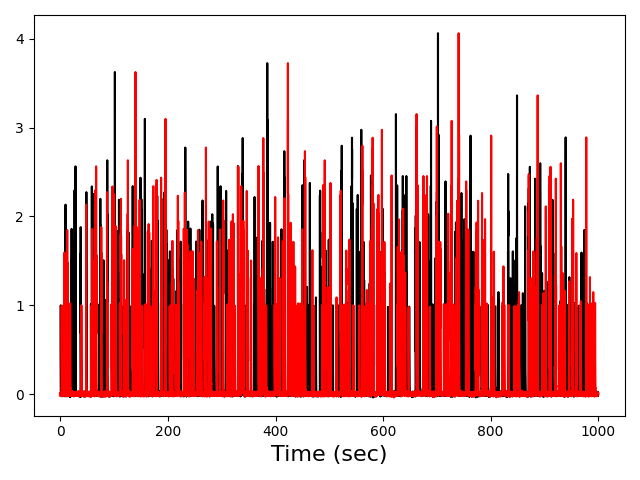

In [21]:

plt.figure()
plt.plot(timevector,calcium_imag,'k')
plt.plot(timevector,calcium_imag_shuffled,'r')
plt.xlabel('Time (sec)', fontsize=16)
plt.tight_layout()
plt.show()

# os.chdir(path + '/figures/')
# plt.savefig('Surrogate_Trace_Example{0}.svg'.format(surr))


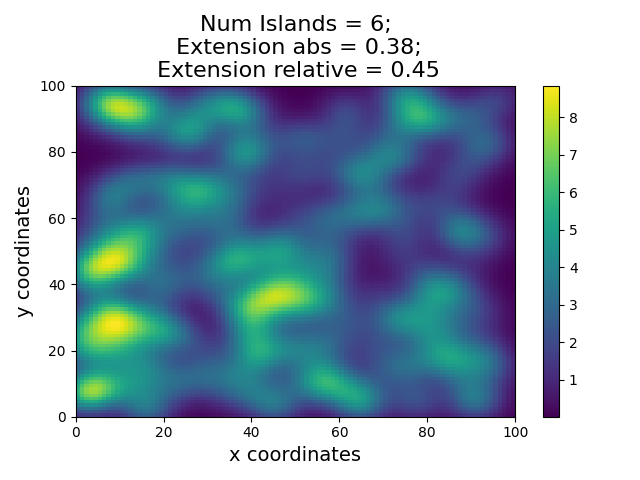

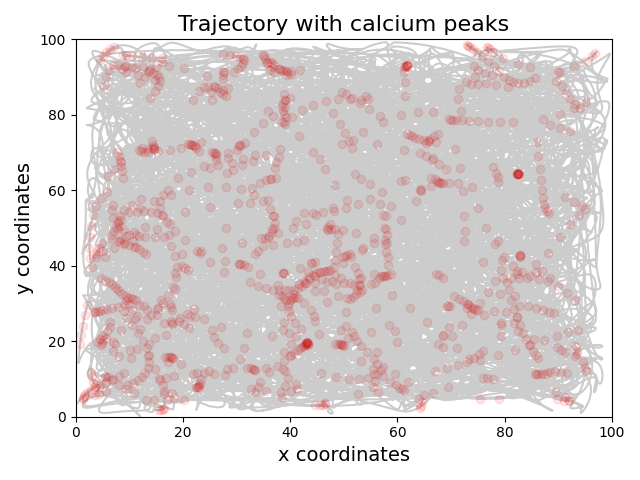

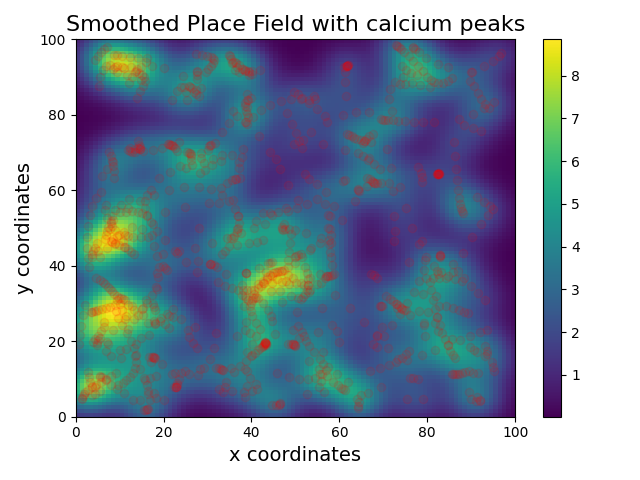

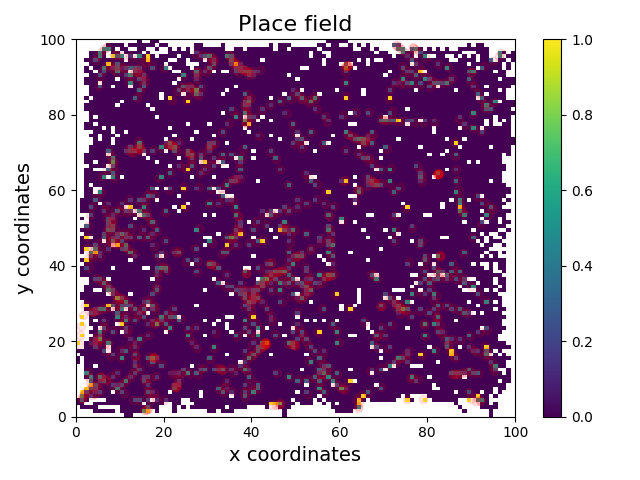

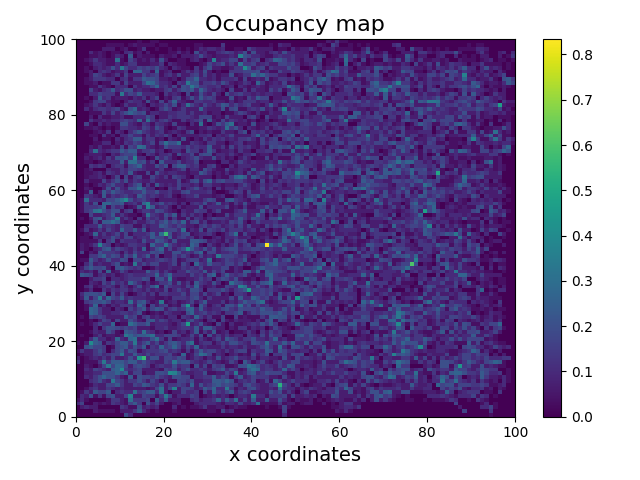

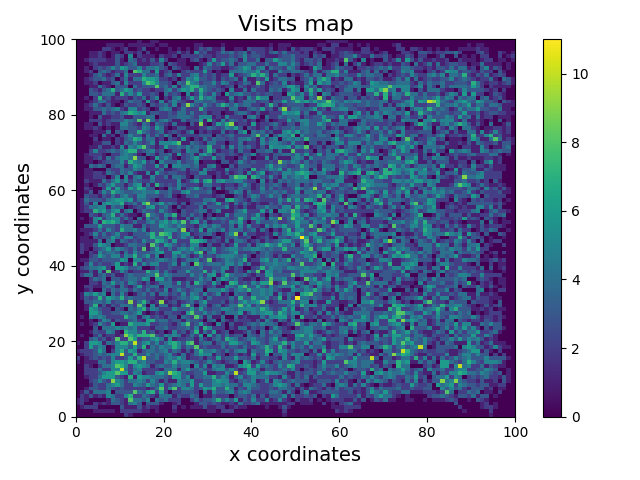

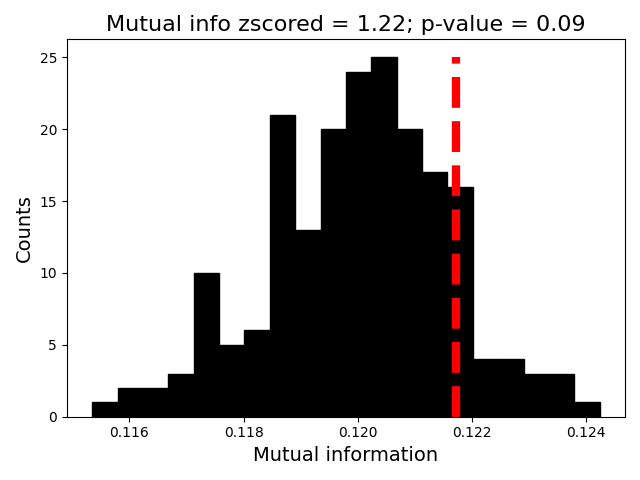

In [26]:


plt.figure()
plt.pcolormesh(place_cell_output_shuff['x_center_bins'],place_cell_output_shuff['y_center_bins'],place_cell_output_shuff['place_field_smoothed'])
plt.colorbar()
plt.title('Num Islands = {0};\n Extension abs = {1:0.2f};\n Extension relative = {2:0.2f}'.format(place_cell_output_shuff['num_of_islands'],place_cell_output_shuff['place_cell_extension_absolute'],place_cell_output_shuff['place_cell_extension_relative']) ,fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



x_peaks_location = place_cell_output_shuff['x_peaks_location']
y_peaks_location = place_cell_output_shuff['y_peaks_location']

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k',alpha=0.2)
plt.scatter(x_peaks_location,y_peaks_location,alpha=0.1,color='red')
plt.title('Trajectory with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


x_peaks_location = place_cell_output_shuff['x_peaks_location']
y_peaks_location = place_cell_output_shuff['y_peaks_location']

    
plt.figure()
plt.pcolormesh(place_cell_output_shuff['x_center_bins'],place_cell_output_shuff['y_center_bins'],place_cell_output_shuff['place_field_smoothed'])
plt.colorbar()
plt.scatter(x_peaks_location,y_peaks_location,alpha=0.1,color='red')
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()




plt.figure()
plt.pcolormesh(place_cell_output_shuff['x_center_bins'],place_cell_output_shuff['y_center_bins'],place_cell_output_shuff['place_field'])
plt.colorbar()
plt.scatter(x_peaks_location,y_peaks_location,alpha=0.1,color='red')
plt.title('Place field',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()




plt.figure()
plt.pcolormesh(place_cell_output_shuff['x_center_bins'],place_cell_output_shuff['y_center_bins'],place_cell_output_shuff['ocuppancy_map'])
plt.colorbar()
plt.title('Occupancy map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()





plt.figure()
plt.pcolormesh(place_cell_output_shuff['x_center_bins'],place_cell_output_shuff['y_center_bins'],place_cell_output_shuff['visits_map'])
plt.colorbar()
plt.title('Visits map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()

# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = np.sum(place_cell_output_shuff['mutual_info_shuffled'] >= place_cell_output_shuff['mutual_info_original'])/place_cell_output_shuff['mutual_info_shuffled'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output_shuff['mutual_info_shuffled'].shape[0]
p_value


counts,bins = np.histogram(place_cell_output_shuff['mutual_info_shuffled'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output_shuff['mutual_info_original'],place_cell_output_shuff['mutual_info_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output_shuff['mutual_info_zscored'],p_value),fontsize=16)
plt.xlabel('Mutual information',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()

